# Sowing Success: How Machine Learning Helps Farmers Select the Best Crops

![Farmer in a field](farmer_in_a_field.jpg)

Measuring essential soil metrics such as nitrogen, phosphorous, potassium levels, and pH value is an important aspect of assessing soil condition. However, it can be an expensive and time-consuming process, which can cause farmers to prioritize which metrics to measure based on their budget constraints.

Farmers have various options when it comes to deciding which crop to plant each season. Their primary objective is to maximize the yield of their crops, taking into account different factors. One crucial factor that affects crop growth is the condition of the soil in the field, which can be assessed by measuring basic elements such as nitrogen and potassium levels. Each crop has an ideal soil condition that ensures optimal growth and maximum yield.

A farmer reached out to you as a machine learning expert for assistance in selecting the best crop for his field. They've provided you with a dataset called `soil_measures.csv`, which contains:

- `"N"`: Nitrogen content ratio in the soil
- `"P"`: Phosphorous content ratio in the soil
- `"K"`: Potassium content ratio in the soil
- `"pH"` value of the soil
- `"crop"`: categorical values that contain various crops (target variable).

Each row in this dataset represents various measures of the soil in a particular field. Based on these measurements, the crop specified in the `"crop"` column is the optimal choice for that field.  

In this project, you will build multi-class classification models to predict the type of `"crop"` and identify the single most importance feature for predictive performance.

In [9]:
# All required libraries are imported here for you.
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np

# Load the dataset
crops = pd.read_csv("soil_measures.csv")

# Write your code here
X = crops.drop('crop', axis=1)
y = crops['crop']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Create DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


# Calculate the feature importance
params = {
    'max_depth':3,
    'learning_rate':0.1,
    'objective':'multi:softmax',
    'eval_metrics':'auc',
    'num_class':22
}

# Train model as a benchmark to see the important features
model = xgb.train(params, dtrain, evals=[(dtrain, 'train'), (dtest, 'test')])

importance = model.get_score(importance_type='weight')


# Organiza the output
best_key = max(importance, key=importance.get)
best_value = importance[best_key]

best_predictive_feature = {best_key: best_value}

print(best_predictive_feature)

[01:54:10] WARNING: ../src/learner.cc:627: 
Parameters: { "eval_metrics" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-mlogloss:2.54642	test-mlogloss:2.56893
[1]	train-mlogloss:2.23053	test-mlogloss:2.26604
[2]	train-mlogloss:2.00031	test-mlogloss:2.04581
[3]	train-mlogloss:1.82113	test-mlogloss:1.87559
[4]	train-mlogloss:1.67140	test-mlogloss:1.72904
[5]	train-mlogloss:1.54466	test-mlogloss:1.60691
[6]	train-mlogloss:1.43683	test-mlogloss:1.50426
[7]	train-mlogloss:1.34086	test-mlogloss:1.40867
[8]	train-mlogloss:1.25464	test-mlogloss:1.32457
[9]	train-mlogloss:1.17863	test-mlogloss:1.24792
{'K': 238.0}


In [10]:
# see the training result as a benchmark
param_grid = {
    'max_depth': [3,5,7],
    'learning_rate': [0.1,0.01,0.001],
    'n_estimators': [100,200,300]
}

def train_model(params):
    model = xgb.train(params, dtrain, num_boost_round=params['n_estimators'])
    preds = model.predict(dtest)
    preds_class = np.argmax(preds, axis=1)
    return accuracy_score(y_test, preds_class)

num_classes = len(np.unique(y_train))

best_score = 0
best_params = None

for max_depth in param_grid['max_depth']:
    for lr in param_grid['learning_rate']:
        for n_estimators in param_grid['n_estimators']:
            params = {
                'max_depth':max_depth,
                'learning_rate': lr,
                'n_estimators': n_estimators,
                'objective': 'multi:softprob',
                'num_class': num_classes
            }
            score = train_model(params)
            if score > best_score:
                best_score = score
                best_params = params

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")
            

[01:54:15] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:54:16] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:54:17] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being use

In [13]:
# train again using best parameters
best_model = xgb.train(best_params, dtrain, num_boost_round=best_params['n_estimators'])
preds = best_model.predict(dtest)
preds_class = np.argmax(preds, axis=1)
accuracy_score(y_test, preds_class)

[02:03:22] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




0.8303030303030303

<Figure size 1000x600 with 0 Axes>

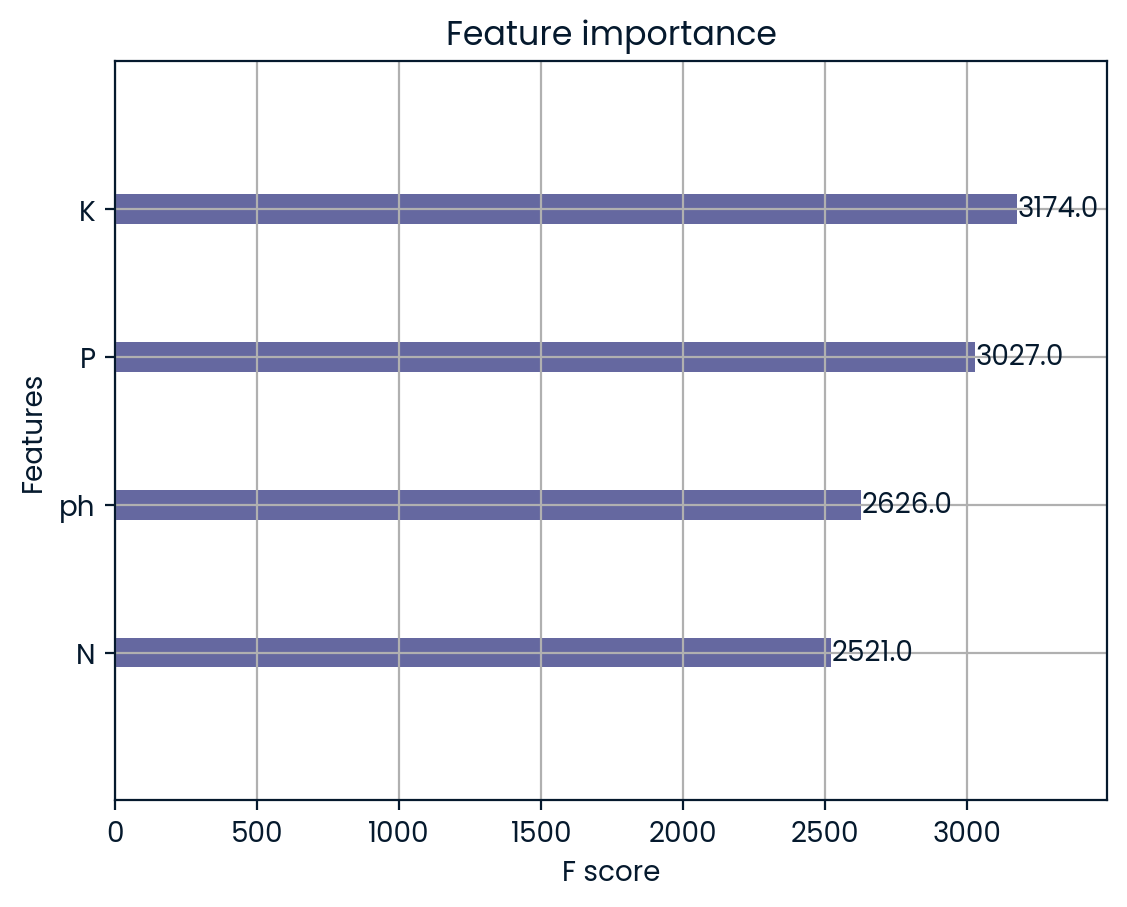

In [14]:
# try to improve the performance
# get feature importance
plt.figure(figsize=(10,6))
xgb.plot_importance(best_model)
plt.show()

In [18]:
# See the target variable's label distribution
distribution = y.value_counts(normalize=True)
proportion = distribution * 100
print(proportion)

rice           4.545455
maize          4.545455
jute           4.545455
cotton         4.545455
coconut        4.545455
papaya         4.545455
orange         4.545455
apple          4.545455
muskmelon      4.545455
watermelon     4.545455
grapes         4.545455
mango          4.545455
banana         4.545455
pomegranate    4.545455
lentil         4.545455
blackgram      4.545455
mungbean       4.545455
mothbeans      4.545455
pigeonpeas     4.545455
kidneybeans    4.545455
chickpea       4.545455
coffee         4.545455
Name: crop, dtype: float64


In [22]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score
from scipy.stats import randint, uniform

# Assume you have already created your DMatrix objects
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameter space
param_dist = {
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(100, 1000),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5)
}

# Fixed parameters
fixed_params = {
    'objective': 'multi:softprob',
    'num_class': len(np.unique(y_train)),  # number of classes
    'eval_metric': 'mlogloss'
}

# Function to sample parameters
def sample_params(param_dist):
    return {k: v.rvs() if hasattr(v, 'rvs') else v for k, v in param_dist.items()}

# Function to train model and return accuracy
def train_and_evaluate(params):
    full_params = {**fixed_params, **params}
    model = xgb.train(full_params, dtrain, num_boost_round=params['n_estimators'])
    preds = model.predict(dtest)
    return accuracy_score(y_test, np.argmax(preds, axis=1))

# Perform random search
n_iter = 50  # Number of iterations
best_score = 0
best_params = None

for _ in range(n_iter):
    params = sample_params(param_dist)
    score = train_and_evaluate(params)
    if score > best_score:
        best_score = score
        best_params = params
    print(f"Iteration {_+1}/{n_iter}, Score: {score:.4f}, Best Score: {best_score:.4f}")

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")


[02:17:05] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Iteration 1/50, Score: 0.8091, Best Score: 0.8091
[02:17:07] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Iteration 2/50, Score: 0.8000, Best Score: 0.8091
[02:17:11] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bi

In [ ]:
# Save the best model
best_model.save_model('--path--')